In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 32

DIRECTORY = r"normalized_dataset"
CATEGORIES = ["bien", "mal", "sin"]

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1109518696407167136
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7079070988128115101
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [4]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    print(path)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
print(trainX.shape, testX.shape)

[INFO] loading images...
normalized_dataset\bien
normalized_dataset\mal
normalized_dataset\sin
(1135, 224, 224, 3) (284, 224, 224, 3)


In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [7]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [8]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/40
35/35 [==============================] - 18s 305ms/step - loss: 0.6203 - accuracy: 0.4959 - val_loss: 0.4542 - val_accuracy: 0.7394
Epoch 2/40
35/35 [==============================] - 10s 275ms/step - loss: 0.4851 - accuracy: 0.6609 - val_loss: 0.3945 - val_accuracy: 0.7887
Epoch 3/40
35/35 [==============================] - 10s 275ms/step - loss: 0.4326 - accuracy: 0.7189 - val_loss: 0.3606 - val_accuracy: 0.8028
Epoch 4/40
35/35 [==============================] - 10s 274ms/step - loss: 0.3971 - accuracy: 0.7625 - val_loss: 0.3335 - val_accuracy: 0.8169
Epoch 5/40
35/35 [==============================] - 10s 274ms/step - loss: 0.3828 - accuracy: 0.7543 - val_loss: 0.3168 - val_accuracy: 0.8239
Epoch 6/40
35/35 [==============================] - 10s 283ms/step - loss: 0.3732 - accuracy: 0.7705 - val_loss: 0.3049 - val_accuracy: 0.8310
Epoch 7/40
35/35 [==============================] - 10s 279ms/step - loss: 0.3638 - accuracy: 0.7724 - val_loss: 0.297

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
9/9 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

        bien       0.83      0.86      0.85        87
         mal       0.81      0.73      0.77        99
         sin       0.89      0.95      0.92        98

    accuracy                           0.85       284
   macro avg       0.84      0.85      0.84       284
weighted avg       0.84      0.85      0.84       284



In [12]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector_v3.model", save_format="h5")

[INFO] saving mask detector model...


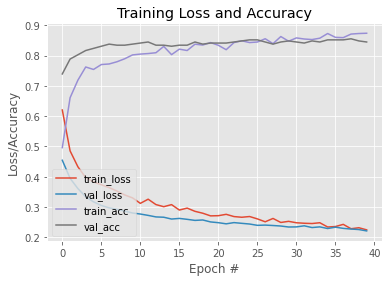

In [13]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotv3.png")